## Pregunta 1: Métodos No lineales

### (a) XOR (disyunción exclusiva)

Este problema encaja con la lógica proposicional del operador lógico XOR. Este operador sólo es Verdadero cuando ambas preposiciones son diferentes, por consiguiente es Falso cuando ambas preposiciones toman el mismo valor. La tabla de verdad para XOR es la siguiente:

|      A     |     B     |  A XOR B  |
|:----------:|:---------:|:---------:|
| Verdadero  | Verdadero |   Falso   |
|  Verdadero |   Falso   | Verdadero |
|    Falso   | Verdadero | Verdadero |
|    Falso   |   Falso   |   Falso   |

Entonces, A y B corresponden al par $x = (x_1, x_2) \in R^2$, con Falso < 0 y Verdadero > 0 y el operador XOR sobre A y B corresponde a la etiqueta $y \in \{-1, 1\}$, siendo en este caso Falso = -1 y Verdadero = 1 obteniendo el problema No lineal deseado.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def do_XOR(n=1000,noisy_n=100,svm=True):
    rng = np.random.RandomState(0)

    # Conjunto de entrenamiento
    X_train = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_train = np.logical_xor(X_train[:,0] > 0, X_train[:,1] > 0)
    Y_train = 2*Y_train-1 if svm else Y_train

    # Generación de ruido
    X_noisy= rng.uniform(low=-0.8,high=0.2,size=(noisy_n,2))
    Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
    Y_noisy = 2*Y_noisy-1 if svm else Y_noisy
    
    # Se incorpora el ruido en el conjunto de entrenamiento
    X_train = np.vstack((X_train, X_noisy))
    Y_train = np.hstack((Y_train, Y_noisy))

    # Conjunto de prueba
    X_test = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    Y_test = 2*Y_test - 1 if svm else Y_test
    
    return X_train,Y_train,X_test,Y_test

X_train,Y_train,X_test,Y_test = do_XOR()

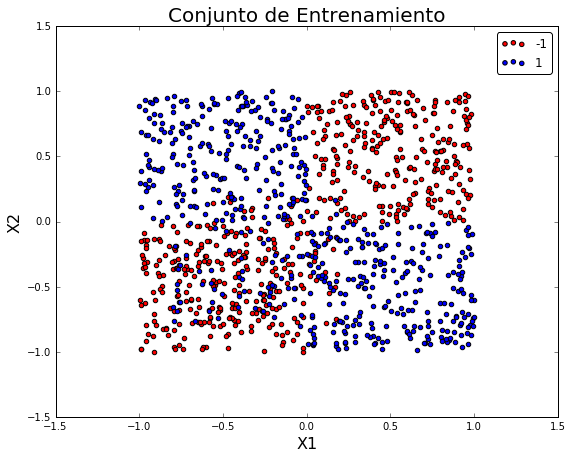

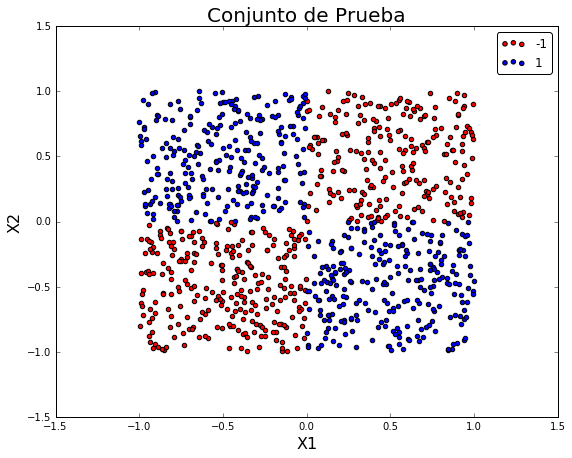

In [3]:
#import seaborn as sns
def plot_data(x, y, title):
    mclasses=(-1,1)
    mcolors = ['red', 'blue']
    plt.figure(figsize=(9, 7))

    for lab, col in zip(mclasses,mcolors):
        plt.scatter(x[y==lab, 0], x[y==lab, 1], label=lab, c=col)

    plt.title(title, fontsize = 20)
    plt.xlabel('X1', fontsize = 16)
    plt.ylabel('X2', fontsize = 16)
    leg = plt.legend(loc='upper right', fancybox=True)

    plt.show()

plot_data(X_train, Y_train, 'Conjunto de Entrenamiento')
plot_data(X_test, Y_test, 'Conjunto de Prueba')

### b) SVM-lineal

Primero se obtiene la probabilidad *a-priori* de cada clase.

In [4]:
prob_negativa = len(X_train[Y_train == -1]) / float(len(X_train[:,0]))
prob_positiva = len(X_train[Y_train == +1]) / float(len(X_train[:,0]))
print "Probabilidad de que un nuevo dato se clasifique en la clase -1: %f"% (prob_negativa)
print "Probabilidad de que un nuevo dato se clasifique en la clase +1: %f"% (prob_positiva)

Probabilidad de que un nuevo dato se clasifique en la clase -1: 0.500909
Probabilidad de que un nuevo dato se clasifique en la clase +1: 0.499091


Por lo que una mejora del $50\%$ significa que el clasificador obtenga un accuracy aproximado de un $75\%$.

In [5]:
#Funciones ocupadas para evaluar los algoritmos y graficar la clasificacion
from sklearn.metrics import classification_report
def score_the_model(model, x, y, xt, yt, text):
    acc_tr = model.score(x, y)
    acc_test = model.score(xt, yt)
    print "Training Accuracy %s: %f"%(text, acc_tr)
    print "Test Accuracy %s: %f"%(text, acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['-1','+1']))
    
def plot_classifier(clf, X_train, Y_train, X_test,Y_test, model_type, title):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10, 10))
    axis.scatter(X_train[:,0],X_train[:,1],s=5,c=Y_train,zorder=10,cmap='gray')
    axis.scatter(X_test[:,0],X_test[:,1],s=15,c=Y_test,zorder=10,cmap='gray')
    XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
    if model_type == 'svm':
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    elif model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: 
        raise ValueError('model type not supported')

    mcolor = plt.cm.Accent
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
    #axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.pcolormesh(XX, YY, Zplot ,cmap=mcolor)
    axis.contour(XX, YY, Z, alpha=1, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],levels=[-1, 0, 1])
    plt.title(title, fontsize = 18)

    plt.show()

In [12]:
from sklearn.svm import LinearSVC

def do_SVM_lineal(x,y,xt,yt,norm):
    Cs = np.logspace(-2, 3,base=10)
    acc_tr = []
    acc_test = []
    models = []
    for C in Cs:
        if(norm == 'l1'):
            model = LinearSVC(C=C, penalty=norm, dual=False)
        else:
            model = LinearSVC(C=C, penalty=norm)

        model = model.fit(x, y)
        acc_tr.append(model.score(x,y))
        acc_test.append(model.score(xt, yt))
        models.append(model)
    
    C_best = Cs[acc_test.index(max(acc_test))]
    model_best = models[acc_test.index(max(acc_test))]
    print "Mejor parámetro de regularización C: %s"%(C_best)
    print "Mejor Accuracy de Test: %f"%(max(acc_test))

    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.plot(Cs,acc_tr,label='Accuracy train')
    ax.plot(Cs,acc_test,label='Accuracy test')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('C', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title('SVM Lineal con penalizacion %s'%(norm), fontsize= 20)
    ax.set_xscale('log')
    plt.show()
    
    return model_best, C_best

Mejor parámetro de regularización C: 0.104811313415
Mejor Accuracy de Test: 0.492000


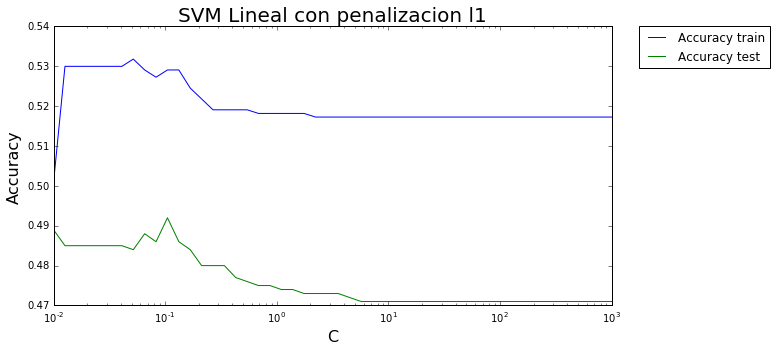

Mejor parámetro de regularización C: 390.693993705
Mejor Accuracy de Test: 0.620000


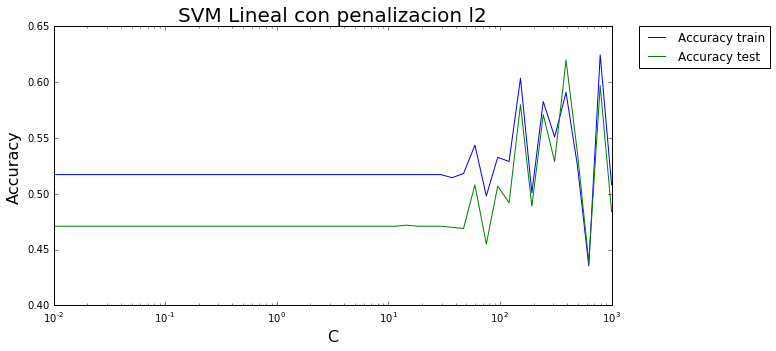

Training Accuracy SVM l1: 0.529091
Test Accuracy SVM l1: 0.492000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.48      0.47      0.47       489
         +1       0.50      0.52      0.51       511

avg / total       0.49      0.49      0.49      1000

Training Accuracy SVM l2: 0.590909
Test Accuracy SVM l2: 0.620000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.97      0.23      0.37       489
         +1       0.57      0.99      0.73       511

avg / total       0.77      0.62      0.55      1000



In [18]:
model1, C = do_SVM_lineal(X_train, Y_train, X_test, Y_test, 'l1')
model2, C = do_SVM_lineal(X_train, Y_train, X_test, Y_test, 'l2')

score_the_model(model1, X_train, Y_train, X_test, Y_test, "SVM l1")
score_the_model(model2, X_train, Y_train, X_test, Y_test, "SVM l2")

Se ejcutan dos SVM lineales una con norma L1 y la otra con norma L2, para parámetros de regularización en el intervalo $C = [10^{-2}, 10^3]$. Para ambos casos se gráfica el comportamiento del parámetro de regularización y se reportan las métricas del mejor caso. Tanto con norma L1 cómo con norma L2 no se logra un accuracy del $75\%$. En el caso de normal L1 se logra un accuracy del $0.49\%$ lo cual es practicamente lo mismo que adivinar el resultado. En cambio, con norma L2 se logra un accuracy del $62\%$, un poco mejor pero no logra el desemepeño deseado. El comportamiento errático aplicando norma L2 a partir de $C > 90$ apróximadamente puede  ser producido por el ruido generado en el *training set*.

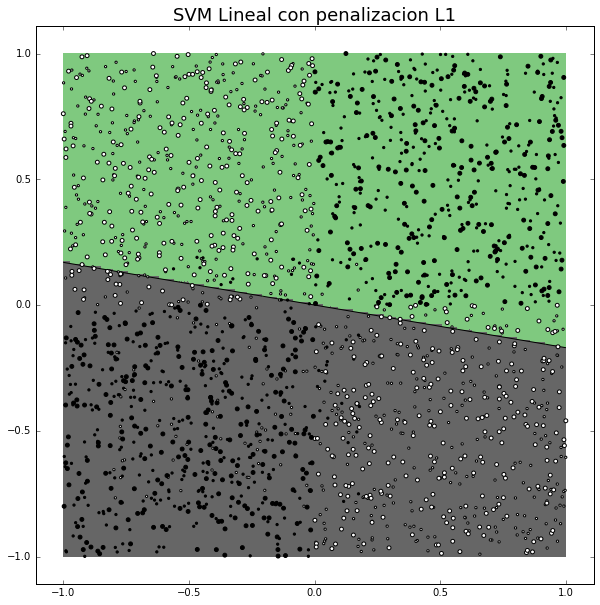

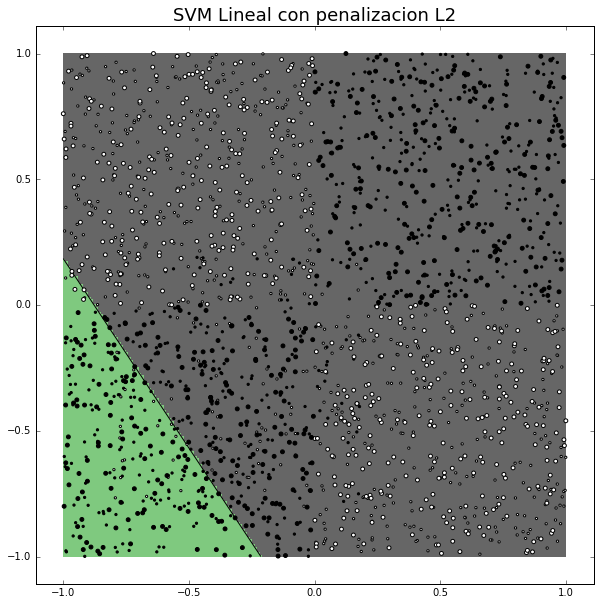

In [19]:
plot_classifier(model1,X_train,Y_train, X_test, Y_test, 'svm', 'SVM Lineal con penalizacion L1')
plot_classifier(model2,X_train,Y_train, X_test, Y_test, 'svm', 'SVM Lineal con penalizacion L2')

Se gráfican los dos mejores desempeños para SVM lineal con norma L1 y L2. Con norma L1 el mejor resultado se obtiene con un parámetro de regularización $C = 0.1$ (penalización alta) y para norma L2 se obtiene cuando $C=391$ (penalización baja). En el caso de norma L1 se observa en la primera figura que básicamente el hiperplano separador traza una recta en el centro de los datos (aproximadamente en $x = 0$), debido a que la alta regularización implica que el hiperplano tiene asociado margenes grandes permiento un mayor error en el clasificador. En cambio, para el caso de norma L2 (segunda figura) regularizar menos implica margenes más ajustados teniendo menor tolerancia a datos mal clasificados, por lo cual el clasificador intenta inclinarse hacia la clasificación de una de las etiqueta de manera completa. En el ejemplo de este todos caso los datos blanco son clasificados bien, pero con el costo de clasificar mal muchos datos negros.

### (c) SVM no lineal

In [41]:
from sklearn.svm import SVC

def do_SVM_no_lineal(x,y,xt,yt,model_type,best):
    Cs = np.logspace(-2, 4,base=2, num=7)
    acc_tr = []
    acc_test = []
    models = []
    for C in Cs:
        if model_type == 'rbf':
            clf = SVC(C=C, kernel='rbf')
        elif model_type == 'poly':
            clf = SVC(C=C, kernel='poly',degree=2, coef0=1)

        clf.fit(X_train, Y_train)
        
        acc_tr.append(clf.score(x,y))
        acc_test.append(clf.score(xt, yt))
        models.append(clf)
    if best:
        C_b = Cs[acc_test.index(max(acc_test))]
        model_b = models[acc_test.index(max(acc_test))]
        print "Mejor parámetro de regularización C: %s"%(C_b)
        print "Mejor Accuracy de Test: %f"%(max(acc_test))
        
        plt.figure(figsize=(10,5))
        ax = plt.gca()
        ax.plot(Cs,acc_tr,label='Accuracy train')
        ax.plot(Cs,acc_test,label='Accuracy test')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel('C', fontsize= 16)
        plt.ylabel('Accuracy', fontsize= 16)
        plt.title('SVM no Lineal con kernel %s'%(model_type), fontsize= 20)
        ax.set_xscale('linear')
        plt.show()

    else:
        C_b = Cs[acc_test.index(min(acc_test))]
        model_b = models[acc_test.index(min(acc_test))]
        print "Peor parámetro de regularización C: %s"%(C_b)
        print "Peor Accuracy de Test: %f"%(min(acc_test))    

    return model_b

Mejor parámetro de regularización C: 8.0
Mejor Accuracy de Test: 0.972000


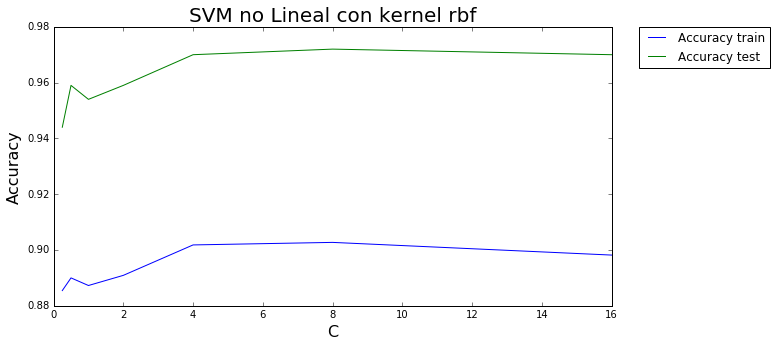

Mejor parámetro de regularización C: 8.0
Mejor Accuracy de Test: 0.955000


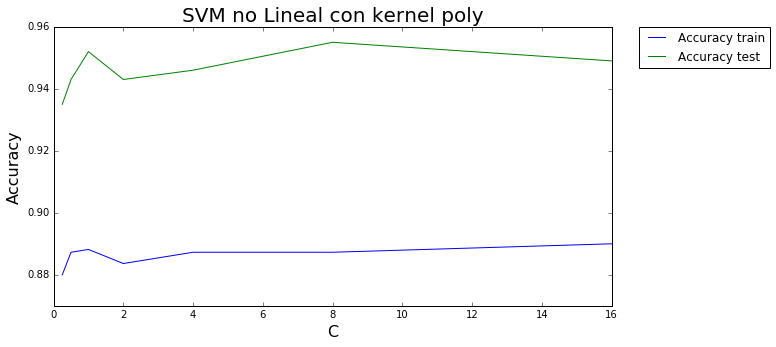

Training Accuracy SVM kernel Gaussiano: 0.902727
Test Accuracy SVM kernel Gaussiano: 0.972000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.95      0.97       489
         +1       0.95      0.99      0.97       511

avg / total       0.97      0.97      0.97      1000

Training Accuracy SVM kernel Polinomial: 0.887273
Test Accuracy SVM kernel Polinomial: 0.955000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.92      0.95       489
         +1       0.93      0.99      0.96       511

avg / total       0.96      0.95      0.95      1000



In [42]:
model_rbf = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'rbf', best=True)
model_poly = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'poly', best=True)

score_the_model(model_rbf, X_train, Y_train, X_test, Y_test, "SVM kernel Gaussiano")
score_the_model(model_poly, X_train, Y_train, X_test, Y_test, "SVM kernel Polinomial")

Se gráfica el accuracy de entrenamiento y de prueba para diferentes parámetros de regularización y se reportan métricas para SVM con kernel Gaussiano (RBF) y polinomial. En primer lugar ambas SVM's logran resolver el problema bastante bien con accuracy de $97.2\%$ y $95.5\%$ para kernel RBF y polinomial respectivamente. Además, en ambos casos el accuracy de entrenamiento es menor al de prueba, esto se debe a que ambos kernel logran determinar la estructura de los datos independiente del ruido generado en el conjunto de entrenamiento. Para ambas SVM's el mejor parámetro de regularización es $C = 8$, por lo cual el hiperplano tendrá un margen más pequeño. En los gráficos se puede observar que amedida que la toleracia a la mala clasificación de datos disminuye (margen más pequeños) se produce un sobre ajuste (overfiting) en los modelos.

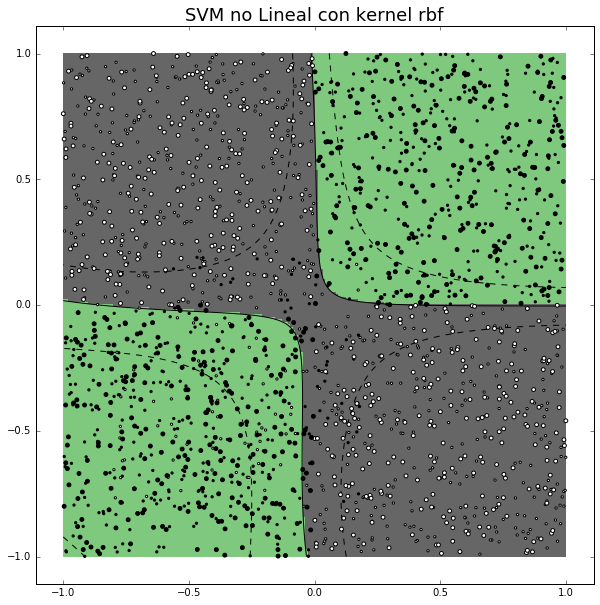

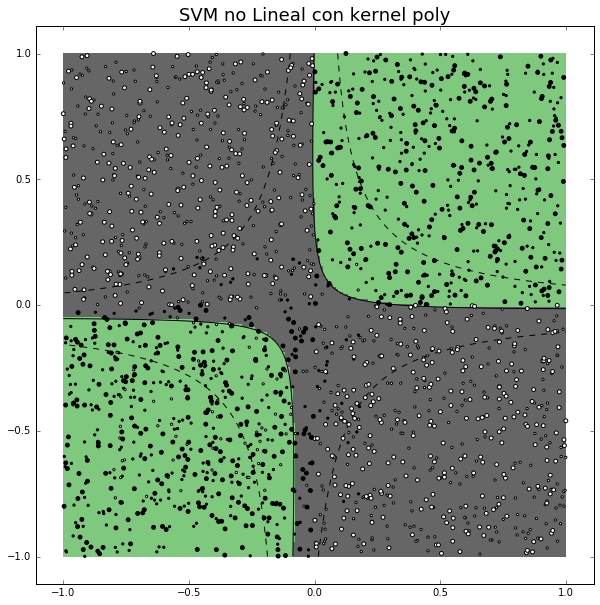

In [43]:
plot_classifier(model_rbf,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel rbf')
plot_classifier(model_poly,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel poly')

Se obtiene los gráficos representativos de las soluciones encontradas para ambos kernel. Se puede ver que tanto el hiperplano Gaussiano y polinomial logran separar de manera correcta los datos. En el caso polinomial la seperación se realiza con una hiperbola. Se puede observar que en el caso de kernel polinomial la curva es mas rigida a diferencia de kernel gaussiano que se ajusta más en los bordes y es más pronunciada (debido a la utilización de la función exponencial). Esto implica un mayor *overfiting* en el kernel Gaussiano.

#### Se vuelve a realizar el experimento pero ahora obtienedo los peores resultados.

Peor parámetro de regularización C: 0.25
Peor Accuracy de Test: 0.944000
Peor parámetro de regularización C: 0.25
Peor Accuracy de Test: 0.935000

Training Accuracy SVM kernel Gaussiano: 0.885455
Test Accuracy SVM kernel Gaussiano: 0.944000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.89      0.94       489
         +1       0.91      0.99      0.95       511

avg / total       0.95      0.94      0.94      1000

Training Accuracy SVM kernel Polinomial: 0.880000
Test Accuracy SVM kernel Polinomial: 0.935000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.88      0.93       489
         +1       0.89      0.99      0.94       511

avg / total       0.94      0.94      0.93      1000



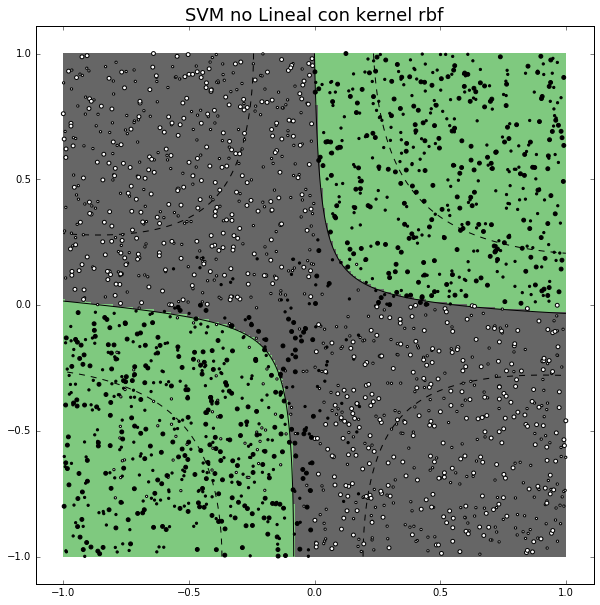

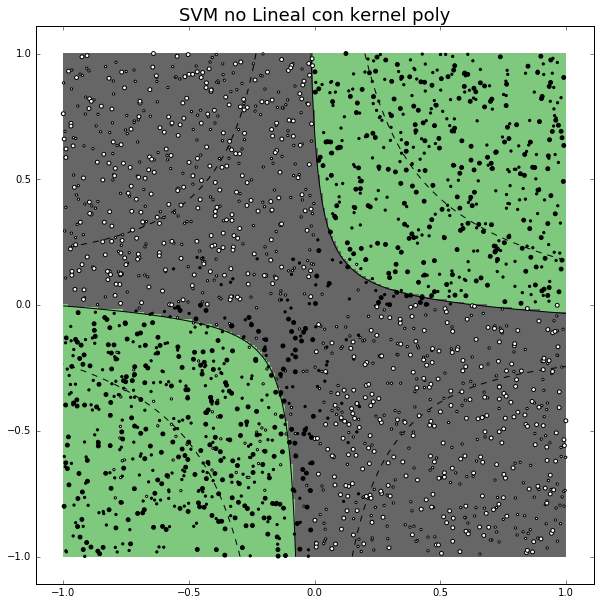

In [47]:
model_rbf = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'rbf', best=False)
model_poly = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'poly', best=False)

print ""

score_the_model(model_rbf, X_train, Y_train, X_test, Y_test, "SVM kernel Gaussiano")
score_the_model(model_poly, X_train, Y_train, X_test, Y_test, "SVM kernel Polinomial")

plot_classifier(model_rbf,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel rbf')
plot_classifier(model_poly,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel poly')

En este caso el parámetro de regularización para ambos kernel es $C=0.25$, es decir, los margen son más grandes (existe una mayor tolerancia a clasificar más los datos). Esto disminuye el *overfiting*, pero también disminuye el accuracy en el conjunto de prueba. De igual manera los desempeños son bastante buenos en ambos clasificadores

### (d) Red Neuronal con sólo 1 neurona

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

n_h=1
model = Sequential()

model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(n_h, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, nb_epoch=30, batch_size=100, verbose=1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Epoch 1/30
1100/1100 [==============================] - 0s - loss: 0.2713 - acc: 0.0200     
Epoch 2/30
1100/1100 [==============================] - 0s - loss: 0.0608 - acc: 0.0000e+00      
Epoch 3/30
1100/1100 [==============================] - 0s - loss: -0.0101 - acc: 0.0000e+00    
Epoch 4/30
1100/1100 [==============================] - 0s - loss: -0.2907 - acc: 0.0000e+00     
Epoch 5/30
1100/1100 [==============================] - 0s - loss: -1.1308 - acc: 0.0000e+00     
Epoch 6/30
1100/1100 [==============================] - 0s - loss: -1.3959 - acc: 0.0000e+00     
Epoch 7/30
1100/1100 [==============================] - 0s - loss: -1.4306 - acc: 0.0000e+00     
Epoch 8/30
1100/1100 [==============================] - 0s - loss: -1.5545 - acc: 0.0000e+00     
Epoch 9/30
1100/1100 [==============================] - 0s - loss: -1.6175 - acc: 0.0000e+00     
Epoch 10/30
1100/1100 [==============================] - 0s - loss: -1.6336 - acc: 0.0000e+00     
Epoch 11/30
1100/1100 [==

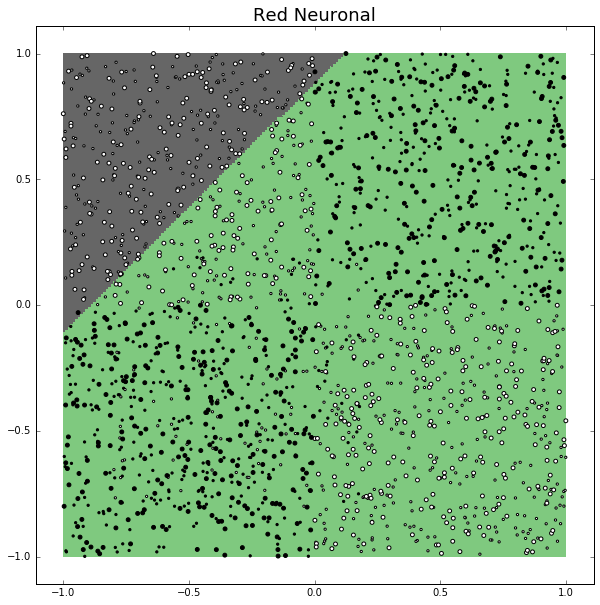

In [12]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann', 'Red Neuronal')

### (e) Red Nueronal con 1 capa

In [ ]:
n_h=8
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(n_h, init='uniform', activation='sigmoid'))

#model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=1,class_weight=None, sample_weight=None)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

In [ ]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann', 'Red Neuronal')

### (f) Árbol de Clasificación de 1 sólo nivel (stump)

Train Accuracy = 0.541818
Test Accuracy = 0.489000
Profundidad del arbol = 1


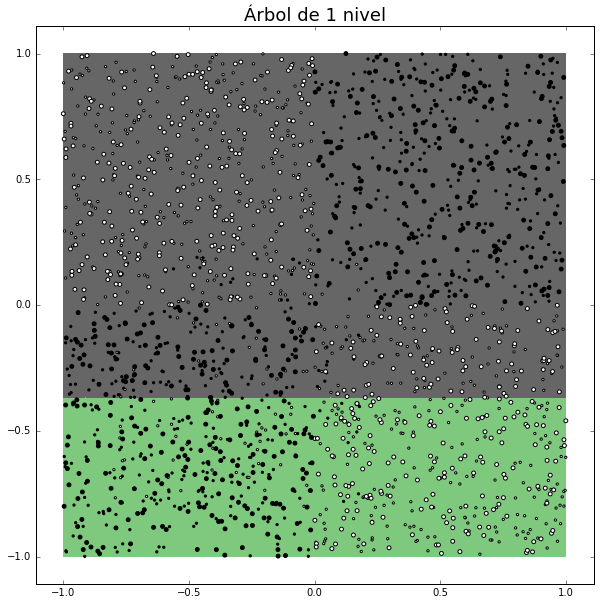

Training Accuracy Arbol stump: 0.541818
Test Accuracy Arbol stump: 0.489000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.48      0.67      0.56       489
         +1       0.50      0.32      0.39       511

avg / total       0.49      0.49      0.47      1000



In [128]:
from sklearn.tree import DecisionTreeClassifier as Tree

n_t=1
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
clf.fit(X_train,Y_train)
acc_tr = clf.score(X_train, Y_train)
acc_test = clf.score(X_test,Y_test)
print "Train Accuracy = %f"%acc_tr
print "Test Accuracy = %f"%acc_test
print "Profundidad del arbol = %d"%clf.tree_.max_depth

plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree', u'Árbol de 1 nivel')
score_the_model(clf, X_train, Y_train, X_test, Y_test, 'Arbol stump')

Se genera un árbol de clasificación de un sólo nivel, y se muestra el mejor resultado. El accuracy de prueba no alcanza el $50\%$ y el gráfico muestra claramente que con un sólo nivel no se logra una correcta separación de los datos. Además, se observa que el corte se realiza en el tercer y cuarto cuadrante, debido al ruido generado en el conjunto de entrenamiento.

### (g) Árbol de clasificación de múltiples niveles

In [150]:
def do_Tree(x,y,xt,yt):
    N_ts = np.linspace(2, 20, num=19)
    acc_tr = []
    acc_test = []
    models = []
    for n_t in N_ts:
        clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
        clf.fit(X_train,Y_train)
        acc_tr.append(clf.score(x,y))
        acc_test.append(clf.score(xt, yt))
        models.append(clf)
    
    model_best = models[acc_test.index(max(acc_test))]
    #print "Número de niveles ideal: %s"%(N_t_best)
    
    print "Profundidad del árbol = %d"%model_best.tree_.max_depth
    print "Mejor Accuracy de Test: %f"%(max(acc_test))
    
    #for i in range(0, len(acc_tr)):
        #acc_tr[i] = 1 - acc_tr[i]
        #acc_test[i] = 1 - acc_test[i]
    
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.plot(N_ts,acc_tr,label='Accuracy train')
    ax.plot(N_ts,acc_test,label='Accuracy test')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('N_t', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title(u'Árbol de clasificacion con múltiples niveles', fontsize= 20)
    ax.set_xscale('linear')
    plt.show()

    return model_best

Profundidad del árbol = 3
Mejor Accuracy de Test: 0.990000


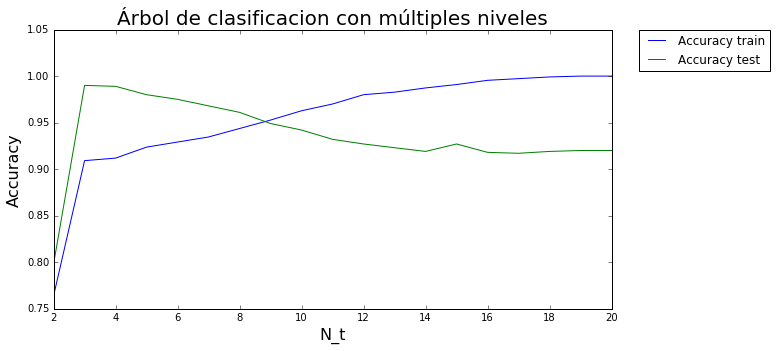

Training Accuracy Árbol Múltiples Niveles: 0.909091
Test Accuracy Árbol Múltiples Niveles: 0.990000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.99      0.99       489
         +1       0.99      0.99      0.99       511

avg / total       0.99      0.99      0.99      1000



In [151]:
model_tree = do_Tree(X_train,Y_train,X_test,Y_test)

score_the_model(model_tree, X_train, Y_train, X_test, Y_test, "Árbol Múltiples Niveles")

Se generan árboles de clasificación con múltiples niveles. El mejor resultado se alcanza con 3 niveles obteniendo un accuracy del $99\%$ en el conjunto de prueba (bastante alto). En el gráfico se observa la curva clasica de sobre ajuste, donde mientras más complejo se vuelve el modelo (más niveles posee el árbol) mayor es el sobre ajuste. El accuracy de entrenamiento aumenta en la medida que el árbol se vuelve más profundo. En cambio, el accuracy de prueba aumenta hasta alcanzar su máximo y luego decae producto del *overfiting*.

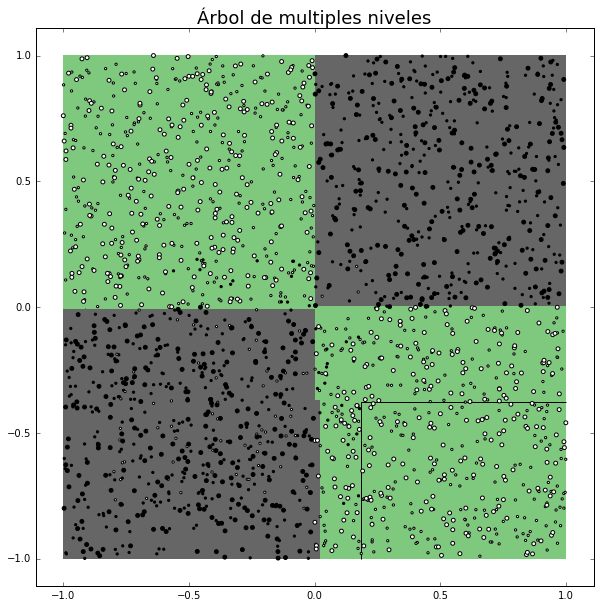

In [152]:
plot_classifier(model_tree,X_train,Y_train,X_test,Y_test,'tree', u'Árbol de multiples niveles')

Se obtiene la representatición gráfica del modelo, donde se puede ver que con tres niveles de profundidad un árbol de clasificación logra separar correctamente los datos.

#### Se realiza el experimento con 19 niveles para ver la clasificación realizada por el árbol (overfiting)

Train Accuracy = 1.000000
Test Accuracy = 0.920000
Profundidad del árbol = 19


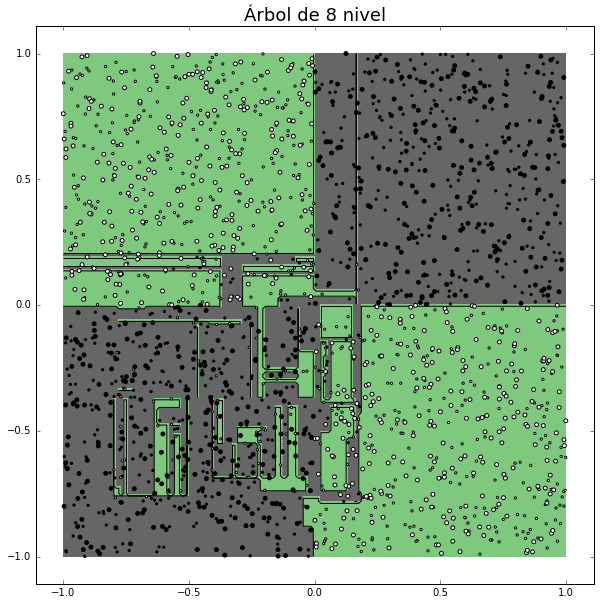

Training Accuracy Arbol: 1.000000
Test Accuracy Arbol: 0.920000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.93      0.90      0.92       489
         +1       0.91      0.94      0.92       511

avg / total       0.92      0.92      0.92      1000



In [147]:
n_t=19
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
clf.fit(X_train,Y_train)
acc_tr = clf.score(X_train, Y_train)
acc_test = clf.score(X_test,Y_test)
print "Train Accuracy = %f"%acc_tr
print "Test Accuracy = %f"%acc_test
print "Profundidad del árbol = %d"%clf.tree_.max_depth

plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree', u'Árbol de 8 nivel')
score_the_model(clf, X_train, Y_train, X_test, Y_test, 'Arbol')

En este caso se observa claramente que se generan reglas de clasificación de manera que todos los datos queden perfectamente clasificados, como se observa en el accuracy del conjunto de entrenamiento que es $1$ (perfecto). El problema de esto, es que el modelo no es robusto (es bastante sensible al ingreso de nuevos datos), por lo que la accuracy de prueba decae al $92\%$, lo cual no es tan malo, pero a medida de que este modelo clasifique más datos sobre todo datos pertenecientes al tercer cuadrante su accuracy irá decallendo.